# Ets in putative heart enhancers

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO

import js # github commit 32863a0 https://github.com/jsolvason/js date May 19 2023
import jsDna as jsd # github commit 32863a0 https://github.com/jsolvason/js date May 19 2023

In [3]:
def loadEts():
    ref  =f'/projects/ps-farleylab/users/solvason/ref/binding-affinity/ets/parsed_Ets1_8mers.txt'              
    Seq2EtsAff  = {line.split('\t')[0]:float(line.split('\t')[1]) for line in open(ref,'r').readlines()}
    return Seq2EtsAff

Ets2Aff=loadEts()

In [5]:
# Load hg38  genome
d="/projects/ps-farleylab/users/solvason/ref/genome/"
def loadHg38():
    file_genome=f'{d}/human/hg38/hg38.fa'
    Handle = open(file_genome, "r")
    chr2seq = SeqIO.to_dict(SeqIO.parse(Handle, "fasta"))
    chr2seq = {chrom:str(chr2seq[chrom].seq).upper() for chrom in chr2seq}
    return chr2seq

# Load 2019 ciona genome
def loadCi19():
    file_genome=f'{d}/ciona/2019/HT.Ref.fasta'
    Handle = open(file_genome, "r")
    chr2seq = SeqIO.to_dict(SeqIO.parse(Handle, "fasta"))
    chr2seq = {chrom:str(chr2seq[chrom].seq).upper() for chrom in chr2seq}
    return chr2seq

# Load genomes

In [6]:
G2Chr2Seq={}

G2Chr2Seq['Ci19']=loadCi19()
G2Chr2Seq['hg38']=loadHg38()

# Analyze ets affinities

In [7]:
Ets2RoundedAff={kmer:round(float(aff),2) for kmer,aff in Ets2Aff.items()}
js.dprint(Ets2RoundedAff,2)

AAAAAAAA 0.15
TTTTTTTT 0.15
AAAAAAAC 0.11


In [8]:
Genome2Organism={
    'Ci19':'Ciona',
    'hg38':'Human'
}

Genome2Name2Bed={
    'Ci19':{'Heart-Open-Chromatin-Racioppi'   :f'Figure4-LacZ_6hpf_13_peaks_noexon_top90.bed'}, # modified this to be correct address
    
    'hg38': {
        'Heart-Put-Dev-Enhancer-Multiple-Datasets-No-Dantonio'    :'Figure4-union-putative-dev-cardiac-enhancers_noDantonio.noexons.sorted.bed'
    }
}

xAdjustCustom=[0,+1,-1,-1,+1]# see cell below to adjust x axis so the dots dont overlap on scatter

 

In [10]:
def get_bp_ref_alt(ref8mer,alt8mer):
    if len(ref8mer)!=len(alt8mer):
        raise ValueError('get_bp_ref_alt(ref8mer,alt8mer)')
        
    for i,(ref,alt) in enumerate(zip(ref8mer,alt8mer)):
        if ref==alt: continue
        else:
            return i,ref,alt
        
get_bp_ref_alt('AAGGAATT','AAGGAAAT')

(6, 'T', 'A')

In [11]:
etsTfCores=set(['GGAA','GGAT','TTCC','ATCC'])


def checkIfSnvCausesDramaticIncrease(ref8mer,Ets2RoundedAff,foldChangeCutoff):
    
    kmer=ref8mer
    aff=Ets2RoundedAff[kmer]
    
    SnvCausesDramaticIncrease=False
    DramaticIncreaseFoldChanges=[]
    DramaticAffinitySnvs=[]
    # If low aff ets, see which snvs cause dramatic affinity increase
    for i in range(len(kmer)):

        # Create all possible snvs
        kmerDegenerate=kmer[:i]+'N'+kmer[i+1:]
        core=kmerDegenerate[2:6]
        
        if core not in etsTfCores: continue 
            
        allSnvs=jsd.GenerateAllPossibleSequences(kmerDegenerate)
        for snv in allSnvs:

            snvAff=Ets2RoundedAff[snv]
            foldChange=snvAff/aff

            # If affinity jump is sufficient, save 
            if foldChange>=foldChangeCutoff:
                SnvCausesDramaticIncrease=True
                DramaticIncreaseFoldChanges.append(foldChange)
                DramaticAffinitySnvs.append(get_bp_ref_alt(ref8mer,snv))
    
    if DramaticIncreaseFoldChanges!=[]:
        return SnvCausesDramaticIncrease,max(DramaticIncreaseFoldChanges),DramaticAffinitySnvs
    else:
        return SnvCausesDramaticIncrease,False,DramaticAffinitySnvs
    
checkIfSnvCausesDramaticIncrease('AAGGAATT',Ets2RoundedAff,3)



(True, 3.5454545454545454, [(6, 'T', 'A'), (6, 'T', 'G')])

# Option 2: Violin + pie chart

In [ ]:

def my_autopct(pct):
    return (f'{int(pct)}%') if pct > 5 else ''

ets=set(['GGAA',jsd.revcomp('GGAA'),'GGAT',jsd.revcomp('GGAT')])
foldChangeCutoff=3


skip_ciona=False #changed this to False
maxBetaLines=1000

allData=[]
allDataLabels=[]
allAverageEtsAffs=[]


line_out_opt_ets_tsv=js.write_row(['chr','hg38-pos0','hg38-pos1','ref','alt'])

for genome in ['Ci19','hg38']:
    
    if genome=='Ci19' and skip_ciona==True:
        continue

    print('---------------------------'*3)
    print(genome)
    print()
    
    # Set up datasets
    Name2KmerSeqAff2Count={}
    Name2FoldChanges     ={}
    
    Name2NPutEns={}
    Name2NEtsInPutEns={}
    
    Name2NPutEnsWithDramaticAffIncrease={}
    Name2NEsInPutEnsWithDramaticAffIncrease={}
    
    #####################################################################################
    # Analyze all datasets
    #####################################################################################
    
    Name2Bed=Genome2Name2Bed[genome]

    for name,bed in Name2Bed.items():
        print('\t',name,bed)
        
        # Set up this dataset
        Name2KmerSeqAff2Count[name]={}
        
        Name2NPutEns[name]=0
        Name2NEtsInPutEns[name]=0
        
        Name2NPutEnsWithDramaticAffIncrease[name]=0
        Name2NEsInPutEnsWithDramaticAffIncrease[name]=0
        
        # Read all lines
        MaxFoldChangeInPutEn=[]
        
        # Keep track of length distribution of regions
        regionLengthDist=[]
        
        # Begin reading file
        for row in js.read_tsv(bed,pc=False,header=False):
                
            chrom,start,end=row[:3]
            start0=int(start)
            end0=int(end)

            regionLengthDist.append(end0-start0)
            
            Name2NPutEns[name]+=1
            thisPutEnHasDramaticAffIncrease=False
            maxEtsFoldChangedObserved=0
            
            
            for kmer8_index,kmer8 in enumerate(jsd.get_kmers(G2Chr2Seq[genome][chrom][start0:end0],8)):
                
                thisEtsHasDramaticAffIncrease=False

                kmer8=kmer8.upper()
                if 'N' in kmer8: continue

                core=kmer8[2:6]

                if core in ets:
                    Name2NEtsInPutEns[name]+=1
                    
                    aff=Ets2RoundedAff[kmer8]

                    if (kmer8,aff) not in Name2KmerSeqAff2Count[name]:
                        Name2KmerSeqAff2Count[name][(kmer8,aff)]=0
                    Name2KmerSeqAff2Count[name][(kmer8,aff)]+=1
                    
                    SnvCausesDramaticIncrease,maxFoldChange,DramaticAffinitySnvs=checkIfSnvCausesDramaticIncrease(kmer8,Ets2RoundedAff,foldChangeCutoff)
                    
                    if SnvCausesDramaticIncrease:
                        if maxFoldChange>maxEtsFoldChangedObserved: maxEtsFoldChangedObserved=maxFoldChange
                        thisEtsHasDramaticAffIncrease  =True
                        thisPutEnHasDramaticAffIncrease=True
                        
                        for rel_8mer_idx,ref,alt in DramaticAffinitySnvs:
                            pos0=start0+kmer8_index+rel_8mer_idx
                            pos1=pos0+1
                            line_out_opt_ets_tsv+=js.write_row([chrom,pos0,pos1,ref,alt])
                            
                        
                        
                if thisEtsHasDramaticAffIncrease:
                    Name2NEsInPutEnsWithDramaticAffIncrease[name]+=1
                    
            if thisPutEnHasDramaticAffIncrease:
                Name2NPutEnsWithDramaticAffIncrease[name]+=1
                MaxFoldChangeInPutEn.append(maxEtsFoldChangedObserved)
            else:
                MaxFoldChangeInPutEn.append(0)
            

        nPutTotal    = Name2NPutEns[name]
        nPutIncrease = Name2NPutEnsWithDramaticAffIncrease[name]
        
        print(name)
        print(f'\tN Put Enhancers Total                             = {nPutTotal:,}')
        print(f'\tN Put Enhancers With Dramatic Aff Increase        = {nPutIncrease:,} ({js.percent(nPutIncrease/nPutTotal)})')
        print()

        nEtsInPutTotal   =Name2NEtsInPutEns[name]
        nEtsInPutIncrease=Name2NEsInPutEnsWithDramaticAffIncrease[name]
        print(f'\tN Ets in Put Enhancers Total                      = {nEtsInPutTotal:,}')
        print(f'\tN Ets in Put Enhancers With Dramatic Aff Increase = {nEtsInPutIncrease:,} ({js.percent(nEtsInPutIncrease/nEtsInPutTotal)})')
        print()
        


        ################################################################
        # Determine all possible SNVs which create dramatic change
        ################################################################

        namePlusSnv='+SNV '+name
        Name2KmerSeqAff2Count[namePlusSnv]={}
        Name2FoldChanges[namePlusSnv]=[]

        for (kmer,aff),count in Name2KmerSeqAff2Count[name].items():

            # If low aff ets, see which snvs cause dramatic affinity increase
            for i in range(len(kmer)):

                # Create all possible snvs
                kmerDegenerate=kmer[:i]+'N'+kmer[i+1:]

                # Only keep snv if snv is in flank
                core=kmerDegenerate[2:6]
                if 'N' in core: continue

                allSnvs=jsd.GenerateAllPossibleSequences(kmerDegenerate)
                for snv in allSnvs:

                    snvAff=Ets2RoundedAff[snv]
                    foldChange=snvAff/aff
                    Name2FoldChanges[namePlusSnv].append(snvAff/aff)

                    # If affinity jump is sufficient, save 
                    if foldChange>=foldChangeCutoff:

                        if (snv,snvAff) not in Name2KmerSeqAff2Count[namePlusSnv]:
                            Name2KmerSeqAff2Count[namePlusSnv][(snv,snvAff)]=0
                        Name2KmerSeqAff2Count[namePlusSnv][(snv,snvAff)]+=count

        ################################################################
        # Violiin plot
        ################################################################

            
        # Data
        Name2AffArray={}
        for dname in Name2KmerSeqAff2Count:
            Name2AffArray[dname]=[]

            for (kmer,aff),count in Name2KmerSeqAff2Count[dname].items():
                Name2AffArray[dname]+=[aff]*count

        snvLabel='+SNVs Opt Aff ≥3-fold\n'
        data=[Name2AffArray[name],Name2AffArray[namePlusSnv]]
        
        # Save data for further analysis
        np.savetxt(name + "_affinities.txt", np.array(data[0]), fmt="%.3f")
        
        allData+=data
        
        avgOpenAff = round(np.median(Name2AffArray[name]),4)
        avgSnvAff  = round(np.median(Name2AffArray[namePlusSnv]),4)

        print(f'Average Putative Dev Enhancer ETS     = {avgOpenAff}')
        print(f'Average Putative Dev Enhancer ETS-SNV = {avgSnvAff}')
        
    
    with open(f'{figname}__potential-opt-snvs.tsv','w') as f: f.write(line_out_opt_ets_tsv)
    

    

# Plot on same x axis

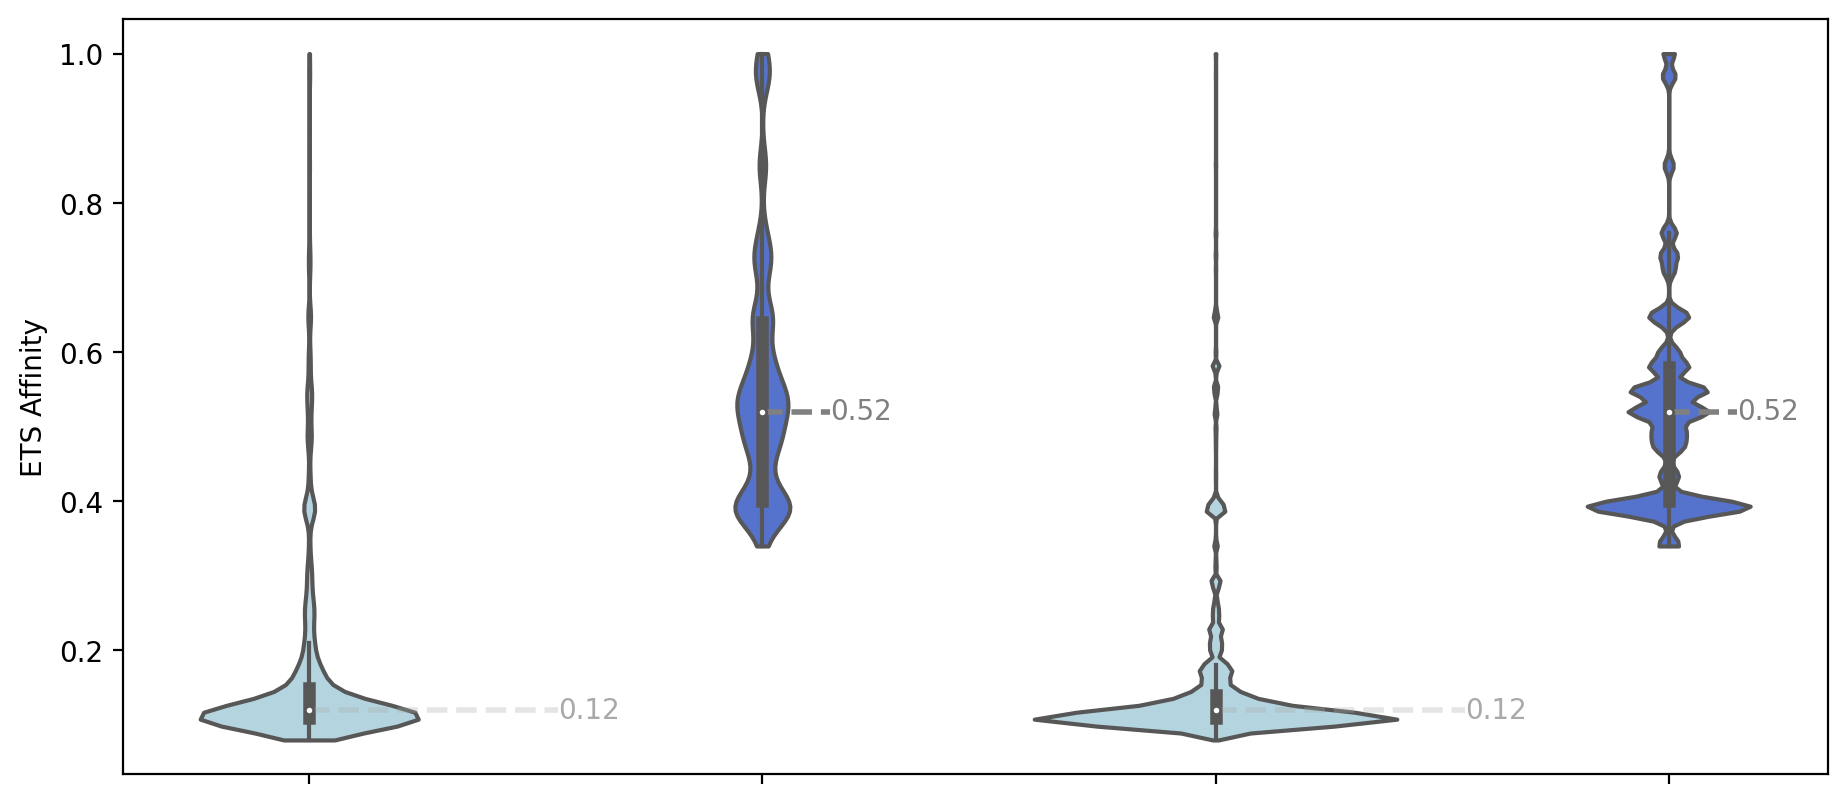

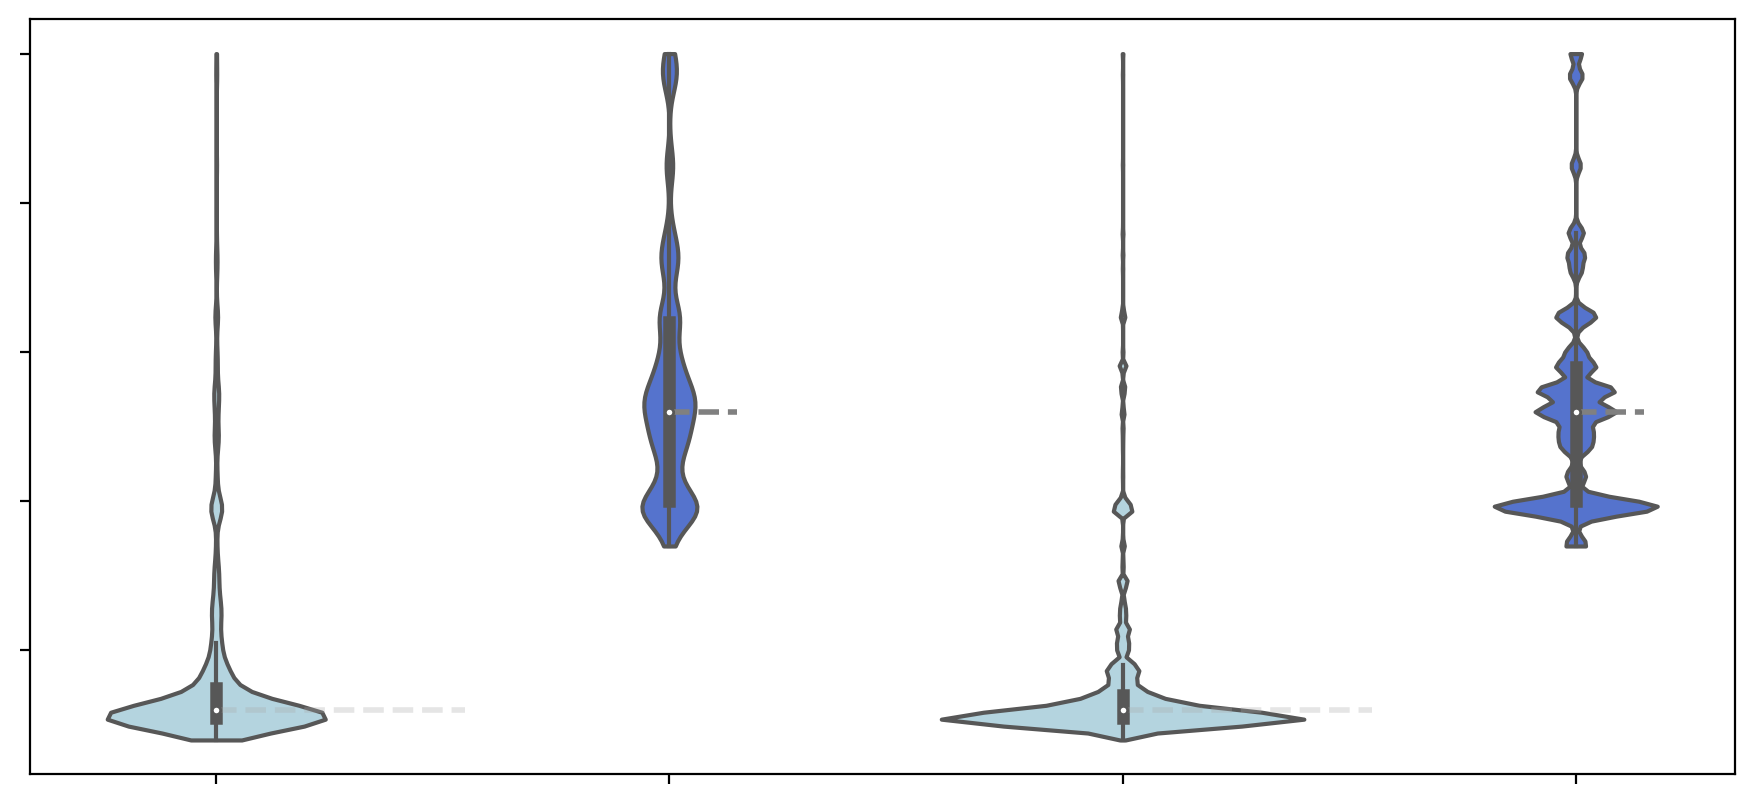

In [15]:
# Recall you have the following data
# allData=[]
# allDataLabels=[]
# allAverageEtsAffs=[]

for text in [True,False]:

    fig,ax=plt.subplots(1,figsize=(11,5),dpi=200)

    sns.violinplot(data=allData,ax=ax,scale='area',palette=['lightblue','royalblue']*2,cut=0)

    for i,avgOpenAff in enumerate([allAverageEtsAffs[0],'NA',allAverageEtsAffs[2],'NA']):
        if avgOpenAff=='NA': continue
        ax.hlines(y=avgOpenAff, xmin=i+0, xmax=i+.55, linewidth=2, color='darkgrey',alpha=.3,ls='--')
        if text: ax.text(y=avgOpenAff,x=i+.55,s=avgOpenAff,va='center',color='darkgrey')

    for i,avgSnvAff in enumerate([allAverageEtsAffs[1],'NA',allAverageEtsAffs[3]]):
        if avgSnvAff=='NA': continue
        ax.hlines(y=avgSnvAff, xmin=i+1, xmax=i+1.15, linewidth=2,  color='grey',alpha=1,ls='--')
        if text: ax.text(y=avgSnvAff,x=i+1.15,s=avgSnvAff,va='center',color='grey')

    if text: ax.set_xticklabels(allDataLabels)
    if text: ax.set_ylabel('ETS Affinity')
    
    else:    ax.set_xticklabels([])
    if not text: ax.set_yticklabels([])
    
    plt.show()
    
    fig.savefig(f"merged-xaxis.text={text}.violin.png", format="png",dpi=300)